# Objetivos

## 1. Propor uma segmentação de perfil baseado no comportamento dos consumidores
## 2. Criar um modelo preditivo visando maximizar os lucros das próximas campanhas de marketing. 

# Importações iniciais

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importação e limpeza de dados

In [90]:
df = pd.read_csv('challenge.csv')

In [91]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [93]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [94]:
# Os únicos valores faltantes são em renda
df.isna().sum().loc[df.isna().sum() > 0]

Income    24
dtype: int64

In [95]:
#Transformando o tipo de dados da coluna Dt_Customer para datetime
df['Dt_Customer'] = df['Dt_Customer'].astype('datetime64')

<AxesSubplot:xlabel='Education'>

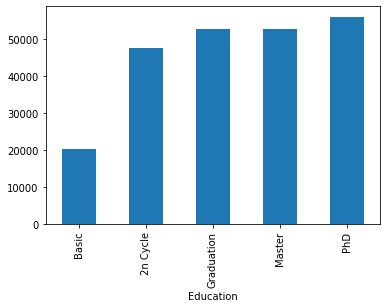

In [96]:
#Existem valores faltantes na coluna Income, vamos preenchê-los com a média de acordo com o nível de educação do cliente
#Primeiramente, vamos agrupar os clientes por nível de educação e evidenciar as médias de suas rendas

inc_educ = df.groupby('Education')['Income'].mean().sort_values()
inc_educ.plot(kind='bar')

### Como esperado, as médias salariais aumentam com o aumento do nível de educação

In [97]:
len(df.loc[df['Income'].isna()])

24

Substituido os valores faltantes de `Income` com a média de salários de acordo com o nível educacional do indivíduo.

In [98]:
df['Income'] = df['Income'].fillna(df.groupby('Education')['Income'].transform('mean'))

In [99]:
df.loc[df['Income'].isna()]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response


Criaremos a feature `TotalCmp` que será o número total de campanhas aceitas pelo usuário. Essa feature poderá refletir a predisposição do usuário a aceitar uma campanha.

In [100]:
df['TotalCmp'] = 0
for col in df.columns:
    if col.startswith('Accepted'):
        df['TotalCmp'] = df['TotalCmp'] + df[col]
df['TotalCmp'].value_counts()

0    1777
1     325
2      83
3      44
4      11
Name: TotalCmp, dtype: int64

`CustomerDays` traduz para dias corridos da data que o cliente se inscreveu na companhia

In [101]:
'''
Aqui a data utilizada para definir o número de dias
corridos desde a inscrição do cliente na companhia é a data
da inscrição do cliente mais recente no dataset
'''
df['CustomerDays'] = df['Dt_Customer'].max() - df['Dt_Customer']
df['CustomerDays'] = df['CustomerDays'].dt.days
df['CustomerDays'].head()

0    663
1    113
2    312
3    139
4    161
Name: CustomerDays, dtype: int64

In [102]:
'''
Aqui a data utilizada para definir a idade
é a data da inscrição do cliente mais recente no dataset
'''

df['Age'] = df['Dt_Customer'].max().year - df['Year_Birth']
df['Age'].head()

0    57
1    60
2    49
3    30
4    33
Name: Age, dtype: int64

In [103]:
'''
Aqui será criada a coluna Children para totalizar o numero de filhos de cada cliente
'''
df['Children'] = df['Kidhome'] + df['Teenhome']
df['Children'].head()

0    0
1    2
2    0
3    1
4    1
Name: Children, dtype: int64

# EDA

## Vamos entender quais as características dos nossos dados

### Iniciaremos pelas características dos clientes como ano de nascimento e outros atributos

### Função auxiliar

In [104]:
def bar_gen(df, col):
    """
    Gera os valores a serem utilizados para criar um barplot
    x = locais dos ticks
    height = altura de cada barra
    tick_labels = labels
    """
    
    x = np.arange(len(df[col].value_counts()))
    height = df[col].value_counts()
    tick_labels = df[col].value_counts().index
    
    return x, height, tick_labels

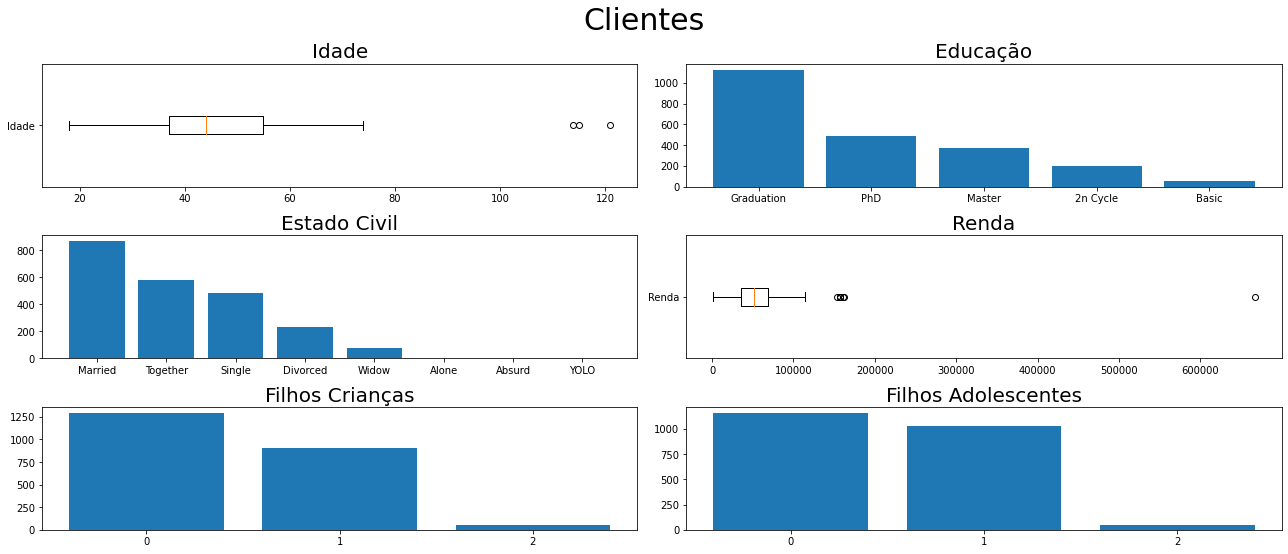

In [105]:
fig=plt.figure(figsize=(18,10))
fig.suptitle('Clientes', fontsize=30)

ax1=fig.add_subplot(4,2,1)
ax1.set_title('Idade', fontsize=20)
ax1.boxplot(df['Age'], vert=False, labels=['Idade'])
ax1.tick_params(axis='x')

x_ed, h_ed, tck_ed = bar_gen(df, 'Education')
ax2=fig.add_subplot(4,2,2)
ax2.set_title('Educação', fontsize=20)
ax2.bar(x_ed, h_ed, tick_label=tck_ed)
ax2.tick_params(axis='x')

x_ms, h_ms, tck_ms = bar_gen(df, 'Marital_Status')
ax3=fig.add_subplot(4,2,3)
ax3.set_title('Estado Civil', fontsize=20)
ax3.bar(x_ms, h_ms, tick_label=tck_ms)
ax3.tick_params(axis='x')

ax4=fig.add_subplot(4,2,4)
ax4.set_title('Renda', fontsize=20)
ax4.boxplot(df['Income'].fillna(df['Income'].mean()), vert=False, labels=['Renda'])
ax4.tick_params(axis='x')

x_kh, h_kh, tck_kh = bar_gen(df, 'Kidhome')
ax5=fig.add_subplot(4,2,5)
ax5.set_title('Filhos Crianças', fontsize=20)
ax5.bar(x_kh, h_kh, tick_label=tck_kh)
ax5.tick_params(axis='x')

x_th, h_th, tck_th = bar_gen(df, 'Teenhome')
ax5=fig.add_subplot(4,2,6)
ax5.set_title('Filhos Adolescentes', fontsize=20)
ax5.bar(x_th, h_th, tick_label=tck_th)
ax5.tick_params(axis='x')

fig.tight_layout()

### Comentários

- `Idade`: Em sua maioria, os clientes tem entre `30` e `60` anos de idade
- `Educação`: Em sua maioria, possuem nível superior
- `Estado Civil`: Em sua maioria, os clientes são casados ou vivem juntos com algum companheiro
- `Renda`: Poucos clientes possuem renda acima de $100.000,00 anual
- `Outliers`: Podemos observar valores bastante divergentes em `Idade` e `Renda`

### Removendo outliers

Os ouliers serão removidos utilizando o cálculo da amplitude interquartílica, que é o mesmo cálculo feito pelo `Matplotlib`
para plotar o gráfico de `Boxplot`.

O dataframe original permanecerá intacto, os novos dados sem os outliers serão armazenados em um novo dataframe: `df2`

In [106]:
def max_range(df, coluna):
    q1 = df[coluna].quantile(q=.25)
    q3 = df[coluna].quantile(q=.75)
    iqr = q3 - q1
    max_range = q3+1.5*iqr
    
    return max_range

In [107]:
outliers_age = max_range(df, 'Age')
outliers_income = max_range(df, 'Income')

In [108]:
#Removendo os outliers
df2 = df.drop(df.loc[df['Age'] > outliers_age].index)
df2 = df2.drop(df2.loc[df['Income'] > outliers_income].index)

Com os ouliers removidos, partimos para uma análise da relação entre o valor total consumido por cada cliente e sua renda

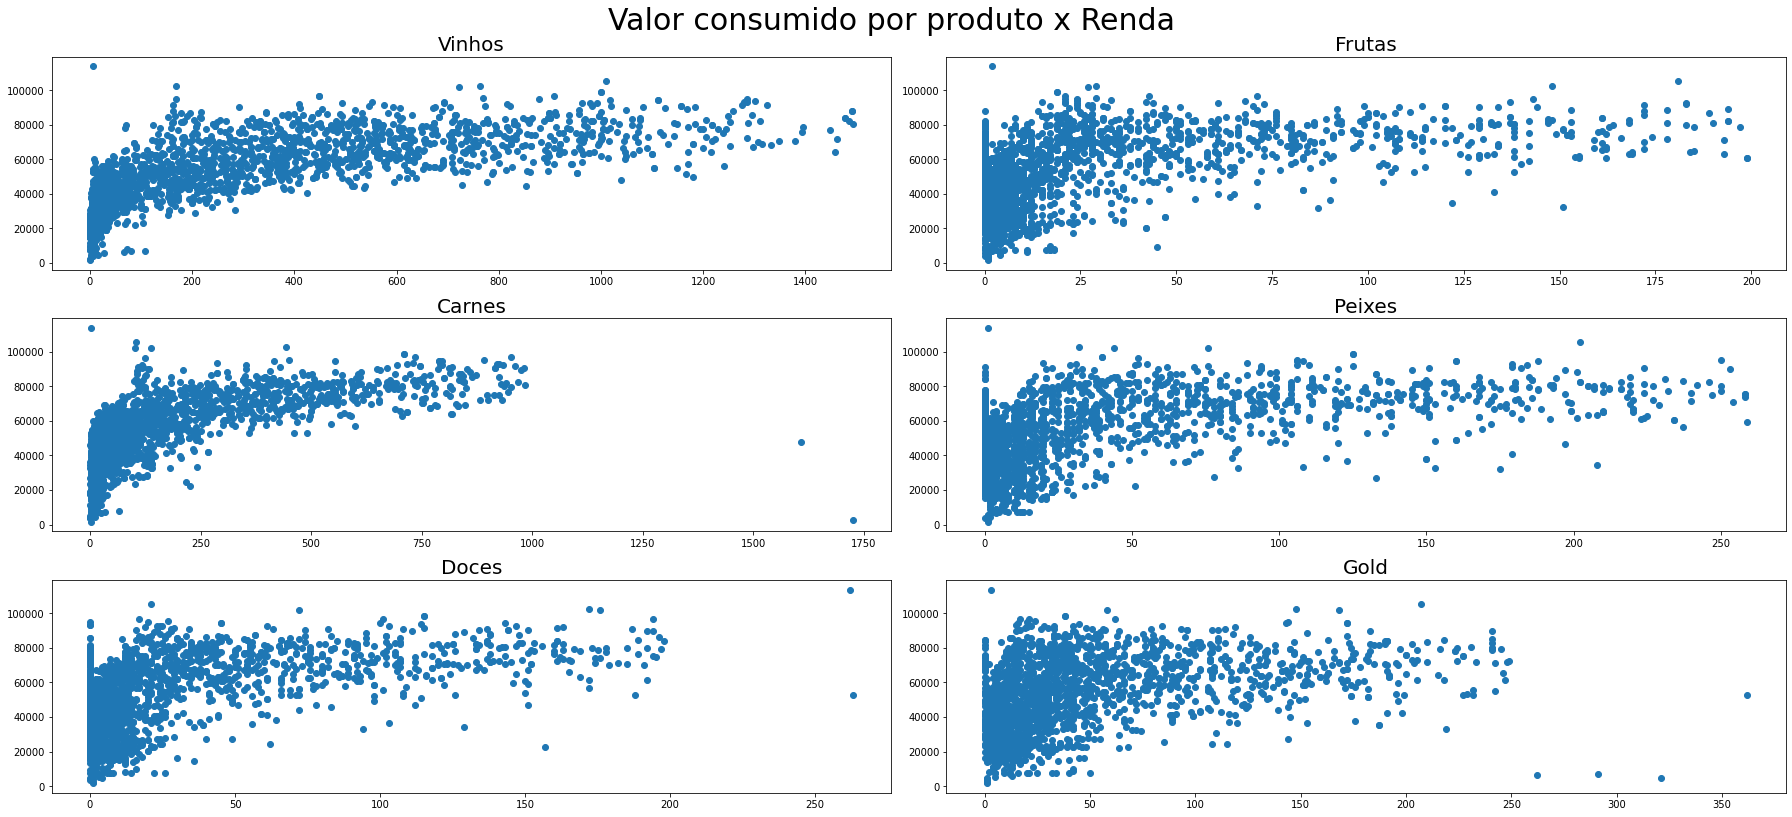

In [109]:
fig2=plt.figure(figsize=(25,15))
fig2.suptitle('Valor consumido por produto x Renda ', fontsize=30)

labels = ['Vinhos', 'Frutas', 'Carnes', 'Peixes', 'Doces', 'Gold']
cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
i=1

for par in zip(labels, cols):
    ax=fig2.add_subplot(4,2,i)
    ax.set_title(par[0], fontsize=20)
    ax.scatter(df2[par[1]], df2['Income'])
    ax.tick_params(axis='x')
    i += 1

fig2.tight_layout()

Podemos observar que existe uma tendencia crescente da renda à medida que o consumo aumente e vice versa

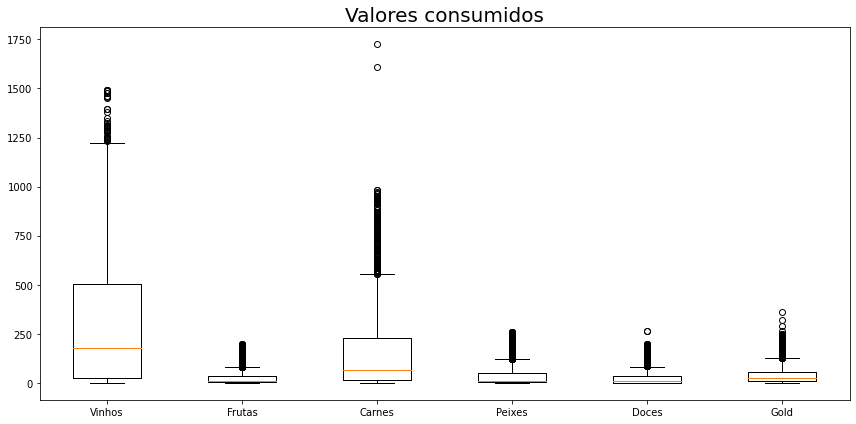

In [110]:
fig3=plt.figure(figsize=(12,6))
ax = fig3.add_subplot(1,1,1)
ax.set_title('Valores consumidos', fontsize=20)
ax.boxplot([df2[name] for name in cols])
ax.tick_params(axis='x')
ax.set_xticklabels(labels)

fig3.tight_layout()

Os produtos com maior valor consumido pela totalidade dos clientes foram `Vinhos` e `Carnes`

In [111]:
df2.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'TotalCmp', 'CustomerDays', 'Age', 'Children'],
      dtype='object')

In [112]:
if 'Income' not in cols:
    cols.append('Income')
correlations = df2[cols].corr()
correlations

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Income
MntWines,1.000000,0.387591,0.586156,0.398024,0.384885,0.384979,0.727982
MntFruits,0.387591,1.000000,0.562744,0.593941,0.566545,0.389145,0.535235
MntMeatProducts,0.586156,0.562744,1.000000,0.589813,0.544347,0.366044,0.692927
MntFishProducts,0.398024,0.593941,0.589813,1.000000,0.578983,0.421147,0.549872
MntSweetProducts,0.384885,0.566545,0.544347,0.578983,1.000000,0.368117,0.549843
MntGoldProds,0.384979,0.389145,0.366044,0.421147,0.368117,1.000000,0.412632
Income,0.727982,0.535235,0.692927,0.549872,0.549843,0.412632,1.000000


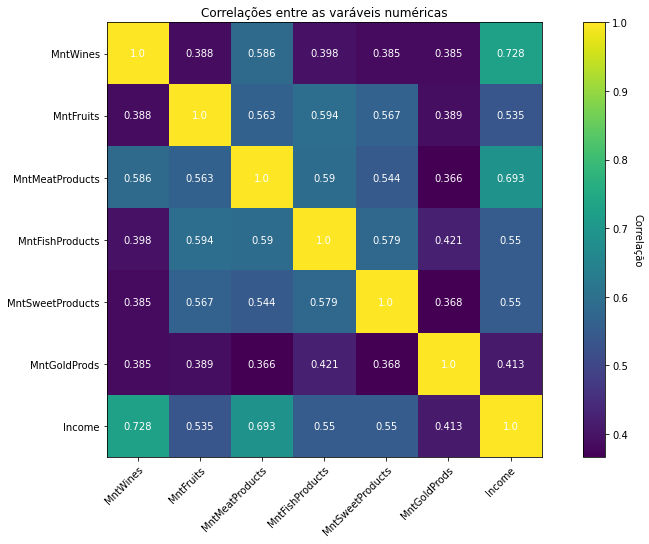

In [113]:
fig, ax = plt.subplots(figsize=[15,8])
im = ax.imshow(correlations)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Correlação', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(correlations)), labels=correlations.columns)
ax.set_yticks(np.arange(len(correlations)), labels=correlations.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(correlations)):
    for j in range(len(correlations)):
        text = ax.text(j, i, np.round(correlations.values[i, j], 3),
                       ha="center", va="center", color="w")

ax.set_title("Correlações entre as varáveis numéricas")
# fig.tight_layout()
plt.show()

Não há um correlação forte entre produtos, indicando que pode não haver produtos complementares, entretanto, podemos ver uma correlação maior entre `Renda` e `Vinhos` e entre `Renda` e `Carnes`, indicando que maiores rendas tendem a consumir mais desses produtos.

- Abaixo faremos uma exploração para entender quais os padrões dos clientes que aceitaram as campanhas anteriores, em comparação à variável resposta, no que diz respeito aos seguintes fatores:   


- Renda
- Idade
- Grau de instrução
- Estado civil
- Nº de filhos

In [114]:
def grupos(df, agrupador, agregador, tipo='numerico'):
    if tipo == 'numerico':
        grupo = df.groupby(agrupador)[agregador].agg(['mean', 'std']).join(df[agrupador].value_counts())
    else:
        grupo = df.groupby([agrupador]).agg({agregador:'value_counts'}).groupby(level=0).apply(lambda x:100 * x / float(x.sum())
                                                                                 ).rename({agregador:'%'}, axis=1)
    return grupo

In [115]:
agrupadores = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

### Renda

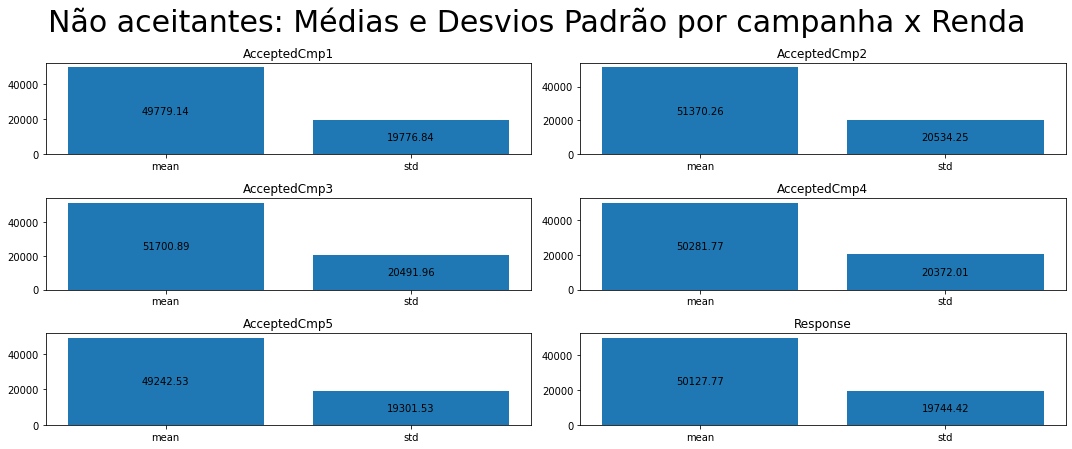

In [117]:
fig4=plt.figure(figsize=(15,8))
fig4.suptitle('Não aceitantes: Médias e Desvios Padrão por campanha x Renda', fontsize=30)
i=1
for agrupador in agrupadores:
    g = grupos(df2, agrupador, 'Income')
    ax = fig4.add_subplot(4,2,i)
    bars = ax.bar([2,3], [g['mean'][0], g['std'][0]])
    ax.set_title(agrupador)
    ax.tick_params(axis='x')
    ax.set_xticks([2,3], labels=['mean', 'std'])
    ax.bar_label(bars, fmt='%.2f', label_type='center')
    i+=1
fig4.tight_layout()

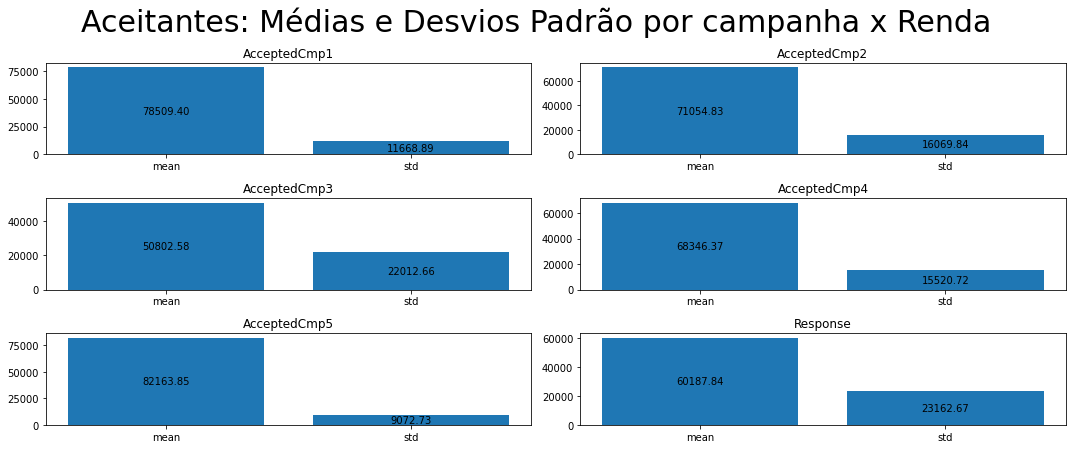

In [118]:
fig5=plt.figure(figsize=(15,8))
fig5.suptitle('Aceitantes: Médias e Desvios Padrão por campanha x Renda', fontsize=30)
i=1
for agrupador in agrupadores:
    g = grupos(df2, agrupador, 'Income')
    ax = fig5.add_subplot(4,2,i)
    bars = ax.bar([2,3], [g['mean'][1], g['std'][1]])
    ax.set_title(agrupador)
    ax.tick_params(axis='x')
    ax.set_xticks([2,3], labels=['mean', 'std'])
    ax.bar_label(bars, fmt='%.2f', label_type='center')
    i+=1
fig5.tight_layout()

- Podemos observar que as médias de renda dos clientes que aceitaram as ofertas 1, 2, 4 e 5 são consideravelmente maiores que as médias dos clientes que não aceitaram as ofertas. A exceção está na campanha 3, que obteve um número de aceitações semelhante com as campanhas posteriores, porém as rendas dos clientes que aceitaram não manteve o mesmo padrão.
- Em `Response`, o mesmo comportamento pode ser visto, porém o desvio padrão é bem maior, sugerindo que clientes com rendas de diversas faixas aceitaram a oferta
- Os desvios padrão dos que aceitaram são menores dos que recusaram, demonstando uma homogeneidade dentre os clientes em torno de uma renda maior, sugerindo que clientes com mais renda são mais propensos a aceitar ofertas. 
- Será interessante investigar quais as características dos clientes que aceitaram cada uma das ofertas, tanto para verificar se essa hipótese de renda maior leva a um maior índice de aceitação, quanto para encontrar novos padrões nesses clientes e entender como cada campanha evoluiu para chegar ao resultado encontrado em `Response`
  

### Idade

<AxesSubplot:ylabel='Frequency'>

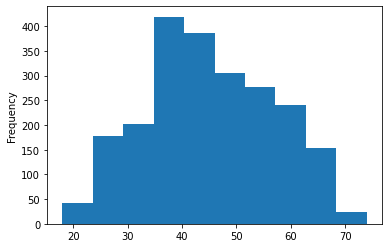

In [119]:
df2['Age'].plot(kind='hist')

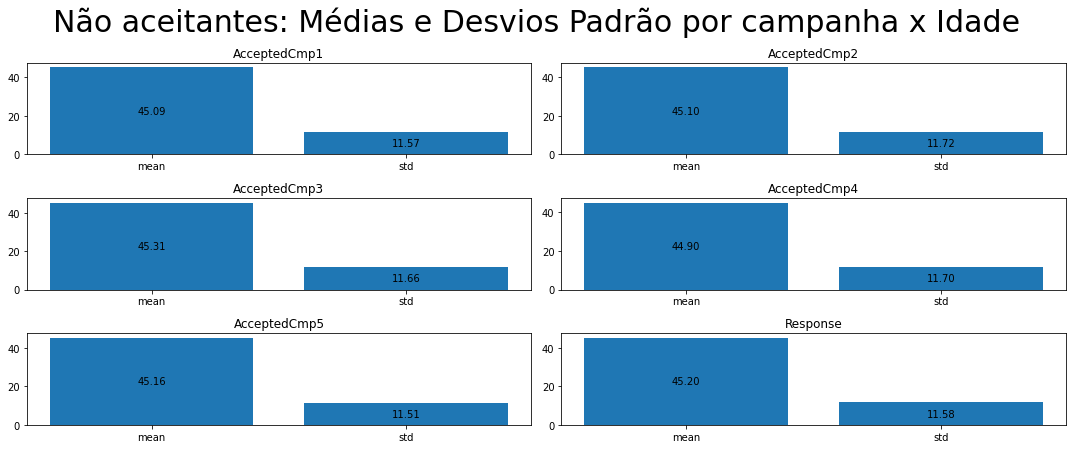

In [120]:
fig6=plt.figure(figsize=(15,8))
fig6.suptitle('Não aceitantes: Médias e Desvios Padrão por campanha x Idade', fontsize=30)
i=1
for agrupador in agrupadores:
    g = grupos(df2, agrupador, 'Age')
    ax = fig6.add_subplot(4,2,i)
    bars = ax.bar([2,3], [g['mean'][0], g['std'][0]])
    ax.set_title(agrupador)
    ax.tick_params(axis='x')
    ax.set_xticks([2,3], labels=['mean', 'std'])
    ax.bar_label(bars, fmt='%.2f', label_type='center')
    i+=1
fig6.tight_layout()

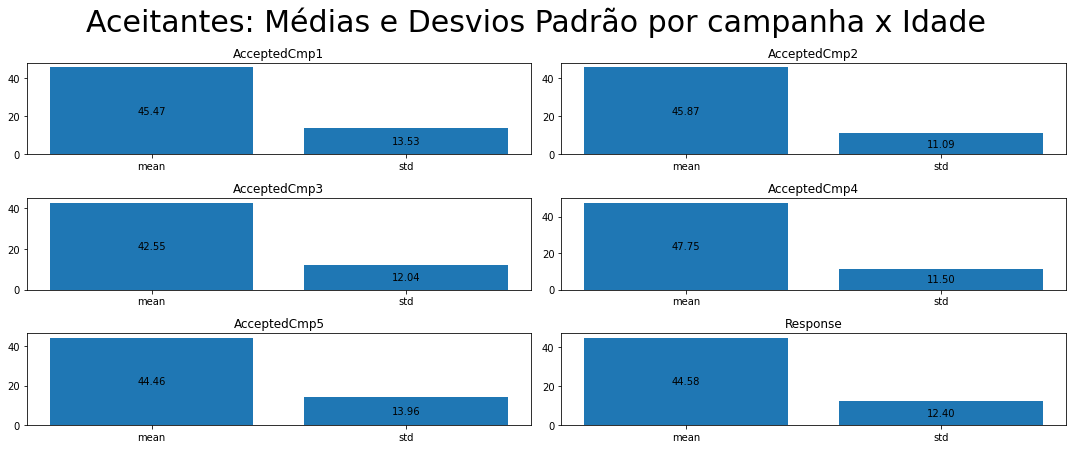

In [121]:
fig7=plt.figure(figsize=(15,8))
fig7.suptitle('Aceitantes: Médias e Desvios Padrão por campanha x Idade', fontsize=30)
i=1
for agrupador in agrupadores:
    g = grupos(df2, agrupador, 'Age')
    ax = fig7.add_subplot(4,2,i)
    bars = ax.bar([2,3], [g['mean'][1], g['std'][1]])
    ax.set_title(agrupador)
    ax.tick_params(axis='x')
    ax.set_xticks([2,3], labels=['mean', 'std'])
    ax.bar_label(bars, fmt='%.2f', label_type='center')
    i+=1
fig7.tight_layout()

### Grau de instrução

<AxesSubplot:>

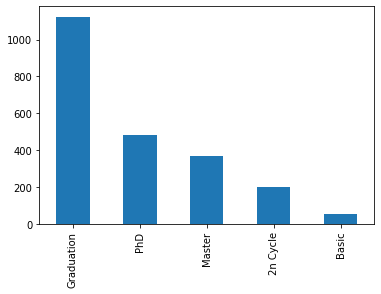

In [122]:
df2['Education'].value_counts().plot(kind='bar')

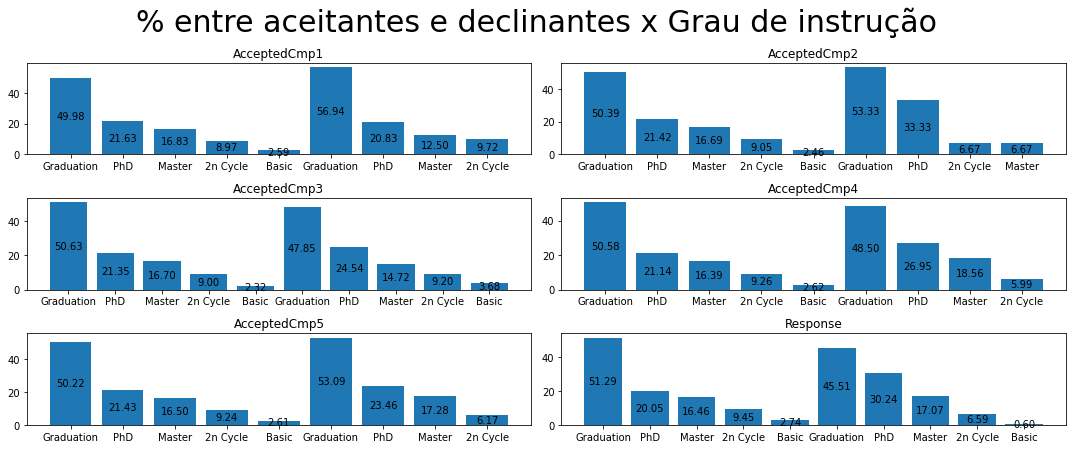

In [123]:
fig8=plt.figure(figsize=(15,8))
fig8.suptitle('% entre aceitantes e declinantes x Grau de instrução', fontsize=30)
i=1
for agrupador in agrupadores:
    g = grupos(df2, agrupador, 'Education', tipo='outro')
    ax = fig8.add_subplot(4,2,i)
    bars = ax.bar(np.arange(len(g)), g['%'])
    ax.set_title(agrupador)
    ax.tick_params(axis='x')
    labels = [x[1] for x in [l for l in g['%'].index]]
    ax.set_xticks(np.arange(len(g)), labels=labels)
    ax.bar_label(bars, fmt='%.2f', label_type='center')
    i+=1
fig8.tight_layout()

### Estado Civil

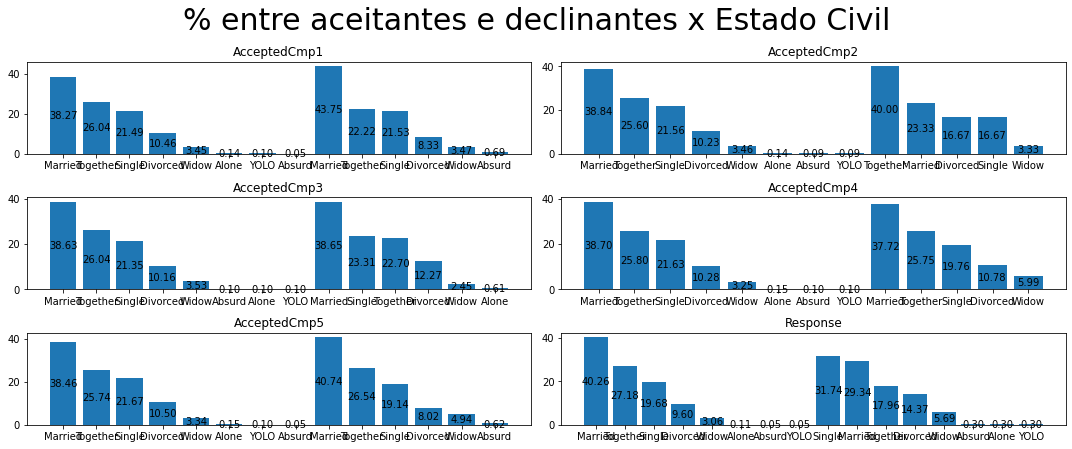

In [124]:
fig9=plt.figure(figsize=(15,8))
fig9.suptitle('% entre aceitantes e declinantes x Estado Civil', fontsize=30)
i=1
for agrupador in agrupadores:
    g = grupos(df2, agrupador, 'Marital_Status', tipo='outro')
    ax = fig9.add_subplot(4,2,i)
    bars = ax.bar(np.arange(len(g)), g['%'])
    ax.set_title(agrupador)
    ax.tick_params(axis='x')
    labels = [x[1] for x in [l for l in g['%'].index]]
    ax.set_xticks(np.arange(len(g)), labels=labels)
    ax.bar_label(bars, fmt='%.2f', label_type='center')
    i+=1
fig9.tight_layout()

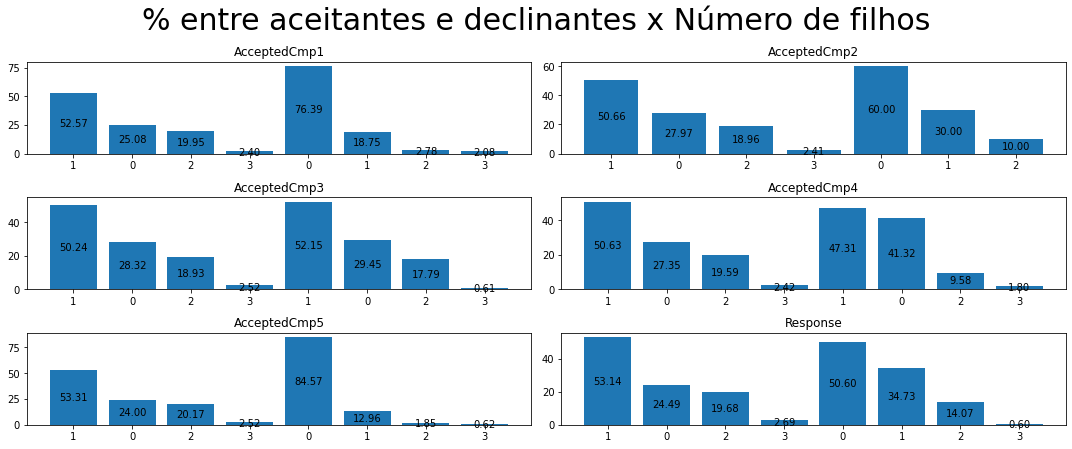

In [125]:
fig10=plt.figure(figsize=(15,8))
fig10.suptitle('% entre aceitantes e declinantes x Número de filhos', fontsize=30)
i=1
for agrupador in agrupadores:
    g = grupos(df2, agrupador, 'Children', tipo='outro')
    ax = fig10.add_subplot(4,2,i)
    bars = ax.bar(np.arange(len(g)), g['%'])
    ax.set_title(agrupador)
    ax.tick_params(axis='x')
    labels = [x[1] for x in [l for l in g['%'].index]]
    ax.set_xticks(np.arange(len(g)), labels=labels)
    ax.bar_label(bars, fmt='%.2f', label_type='center')
    i+=1
fig10.tight_layout()

### Evolução do número de clientes ao longo do tempo

<AxesSubplot:>

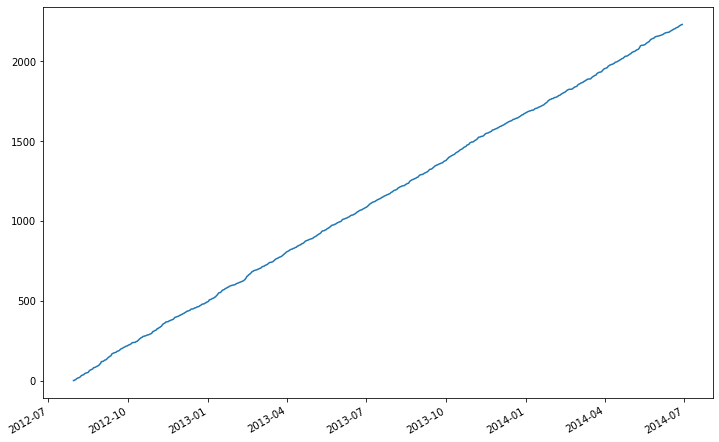

In [126]:
df2['Dt_Customer'].sort_values().value_counts(sort=False).cumsum().plot(figsize=(12,8))

## Nível de aceitação por campanha x Variável resposta

### Queremos descobrir qual campanha obteve mais aceitação em comparação à variável resposta
 

In [127]:
aceitos = {}
for col in df2.columns:
    if col.startswith('Accepted'):
        aceito = 'Campanha ' + col[-1]
        aceitos[aceito] = df2.loc[(df[col] == 1) & (df2['Response'] == 1)]['Response'].sum()
aceitos = pd.Series(aceitos)

In [128]:
a_ordem = aceitos.sort_values(ascending=False)

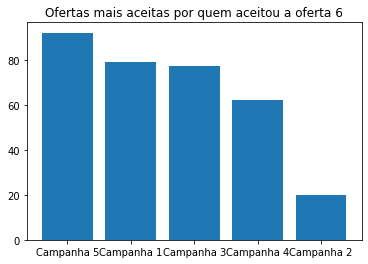

In [129]:
plt.bar(np.arange(len(aceitos)), a_ordem, tick_label=a_ordem.index)
plt.title('Ofertas mais aceitas por quem aceitou a oferta 6')
plt.show()

O gráfico acima mostra a quantidade de usuários que aceitaram a campanha 6 e quais campanhas anteriores foram mais aceitas.  
Nesse caso, a campanha 5 foi a mais aceita dentre os usuários que aceitaram a campanha 6, seguida pelas campanhas 1, 3, 4 e por último, campanha 2.  
Essa análise é importante para destacar eventuais similaridades e divergências entre as campanhas mais aceitas anteriormente, uma informação util futuramente para o time de marketing.

In [130]:
q = df2['MntWines'].quantile(q=.95)

In [131]:
df2.loc[df2['MntWines'] > q].groupby(['Children', 'Education'])['Marital_Status'].value_counts()

Children  Education   Marital_Status
0         Graduation  Married            5
                      Single             5
                      Together           5
                      Divorced           2
                      Widow              1
          Master      Single             6
                      Married            5
                      Together           4
                      Divorced           1
          PhD         Married           14
                      Single             7
                      Together           4
                      Divorced           2
                      Widow              1
1         2n Cycle    Divorced           1
                      Married            1
          Graduation  Married            6
                      Together           6
                      Divorced           3
                      Single             1
          Master      Married            3
                      Divorced           1
                 

### Segmentações

Vamos responder ao primeiro topico do desafio e segmentar de acordo com o observado nos gráficos anteriores, podemos destacar alguns padrões:

- A maioria dos clientes possuem nível superior (`Graduation` e `PhD`), tanto os que aceitaram quanto os que recusaram as ofertas
- Quanto ao estado civil, os clientes ficam bem divididos entre os que estão em algum relacionamento (`Married` e `Together`) e os solteiros (`Single`)
- Com relação ao número de filhos, são poucos os que possuem `3`, a maioria possui no máximo `1`, porém, a quantidade de clientes que possui `0` e `2` filhos é considerável

- Clientes com grau superior de instrução, casados ou juntos, com um filho, tem preferencia por vinhos

# Modelagem de dados

Vamos escolher 3 modelos de classificação:
- Logistic Regression
- KNN
- Decision Tree

Vamos verificar as seguintes métricas para cada modelo e decidir qual o modelo mais apropriado para classificar os clientes:
- Acuracy
- Precision
- Recall
- Score F1
- Curva ROC

Vamos visualizar também a matriz de confusão para ter ideia dos erros e acertos de cada modelo

Iremos utilizar o `Pipeline` e o `ColumnTransformer` do scikit-learn para auxiliar no processo

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, auc, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split

## Preparação

Na etapa de preparação dos dados, vamos transformar as variáveis qualitativas com o `OneHotEncoder` e as variáveis numéricas serão padronizadas com o `StandardScaler`

In [134]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [135]:
#Definindo X e Y
X = df2.drop(['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Response'], axis=1)
Y = df2['Response']

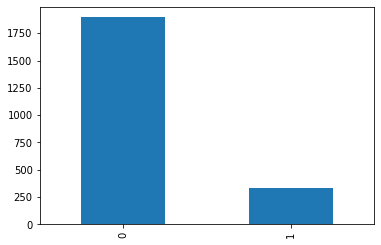

In [136]:
Y.value_counts().plot(kind='bar')
plt.show()

Há um desbalanceamento grande na variável resposta, testaremos os modelos para saber se eles performaram bem nesse estado

In [137]:
#Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [138]:
#Tratar as colunas categóricas
categoricas = ['Education', 'Marital_Status']
cat_encoder = Pipeline(steps=[('str', OneHotEncoder())])
#Tratar as colunas numéricas
numericas = X.select_dtypes(include=['number']).columns
num_encoder = Pipeline(steps=[('num', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('str', cat_encoder, categoricas),
    ('num', num_encoder, numericas)
])

## Criação do Pipeline e modelagem

In [139]:
regressores = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier()]
modelos = []
for regressor in regressores:
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    model = pipe.fit(X_train, y_train)
    modelos.append(model)

## Matrizes de confusão e métricas

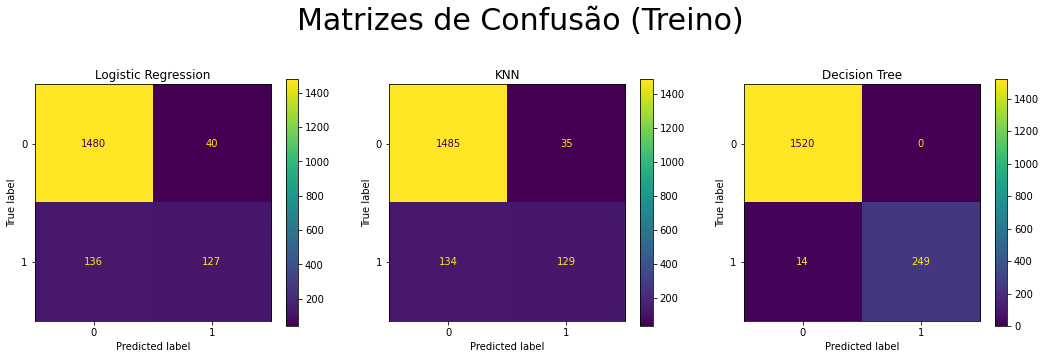

In [140]:
fig11=plt.figure(figsize=(18,10))
fig11.suptitle('Matrizes de Confusão (Treino)', fontsize=30)
titulos=['Logistic Regression', 'KNN', 'Decision Tree']
i=0
for modelo in modelos:    
    ax1 = fig11.add_subplot(2,3,i+1)
    ax1.set_title(titulos[i])
    predict = modelo.predict(X_train)
    ConfusionMatrixDisplay.from_predictions(y_train, predict, ax=ax1)
    i+=1

### Métricas de treino

In [141]:
i = 0
for modelo in modelos:
    accuracy = modelo.score(X_train, y_train)
    predict = modelo.predict(X_train)
    precision = precision_score(y_train, predict)
    recall = recall_score(y_train, predict)
    f1 = f1_score(y_train, predict)
    print(titulos[i])
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 Score: ', f1,'\n')
    
    i+=1

Logistic Regression
Accuracy:  0.9012899607403253
Precision:  0.7604790419161677
Recall:  0.4828897338403042
F1 Score:  0.5906976744186048 

KNN
Accuracy:  0.9052159282108806
Precision:  0.7865853658536586
Recall:  0.49049429657794674
F1 Score:  0.6042154566744731 

Decision Tree
Accuracy:  0.9921480650588895
Precision:  1.0
Recall:  0.9467680608365019
F1 Score:  0.97265625 



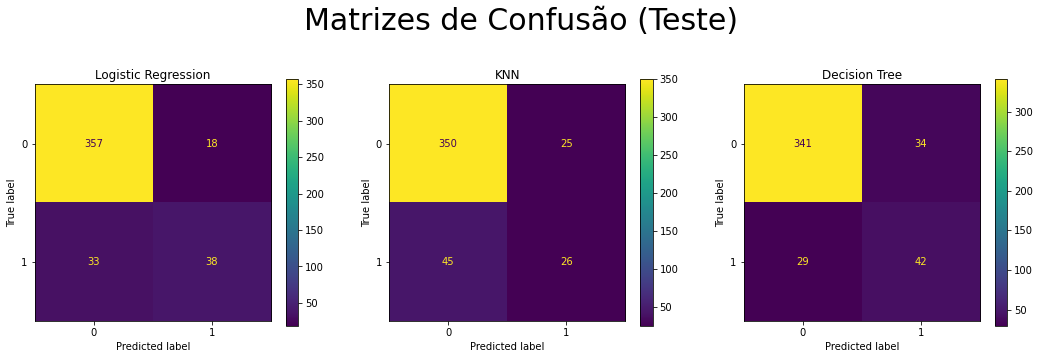

In [142]:
fig12=plt.figure(figsize=(18,10))
fig12.suptitle('Matrizes de Confusão (Teste)', fontsize=30)
titulos=['Logistic Regression', 'KNN', 'Decision Tree']
i=0
for modelo in modelos:    
    ax1 = fig12.add_subplot(2,3,i+1)
    ax1.set_title(titulos[i])
    predict = modelo.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, predict, ax=ax1)
    i+=1

### Métricas de teste

In [143]:
i = 0
for modelo in modelos:
    accuracy = modelo.score(X_test, y_test)
    predict = modelo.predict(X_test)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)
    f1 = f1_score(y_test, predict)
    print(titulos[i])
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 Score: ', f1,'\n')
    
    i+=1

Logistic Regression
Accuracy:  0.8856502242152466
Precision:  0.6785714285714286
Recall:  0.5352112676056338
F1 Score:  0.5984251968503937 

KNN
Accuracy:  0.8430493273542601
Precision:  0.5098039215686274
Recall:  0.36619718309859156
F1 Score:  0.42622950819672134 

Decision Tree
Accuracy:  0.8587443946188341
Precision:  0.5526315789473685
Recall:  0.5915492957746479
F1 Score:  0.5714285714285715 



#### ROC Curve (Teste)

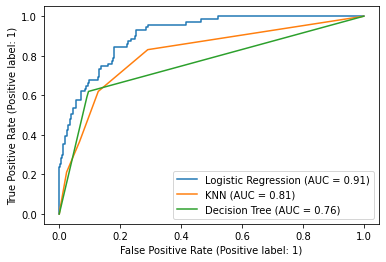

In [144]:
i=0
for modelo in modelos:
    prob = modelo.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1])
    roc_auc = auc(fpr, tpr)
    ax=plt.gca()
    display = RocCurveDisplay.from_estimator(modelo, X_test, y_test, ax=ax, name=titulos[i])
    i+=1

O modelo que manteve mais coerencia entre as métricas de treino e teste foi o `Logistic Regression`, mas a possibilidade de haver overfitting não pode ser descartada.

### Retorno financeiro

Vamos calcular o retorno financeiro dos modelos baseado na matriz de confusão de teste de cada modelo.

Utilizando as informações do dataset, o custo de contato com cada cliente foi de 3 unidades monetárias enquanto a receita gerada foi de 11 unidades monetárias.

total previsto corretamente pelo modelo (tp)
total previsto incorretamente pelo modelo (fp)

O cálculo será feito da seguinte forma:

`(tp * 11) - (tp * 3) - (fp * 3) = lucro/prejuízo total gerado pelo modelo`

Vamos comparar com o retorno financeiro possível caso o modelo acertasse todas as classificações

In [145]:
i=0
for modelo in modelos:
    predict = modelo.predict(X_test)
    cm = confusion_matrix(y_test, predict)
    print(f'Retorno positivo {titulos[i]}')
    tn, fp, fn, tp = cm.ravel()
    lp = (tp*11)-(tp*3)-(fp*3)
    rp = ((tp + fn)*11) - ((tp + fn)*3)
    print(f'${lp}' if lp > 0 else f'-${abs(lp)}')
    print('Retorno financeiro possível')
    print(f'${rp}')
    print(f'Taxa de retorno: {100*(lp/rp):.2f}%\n')
    i+=1

Retorno positivo Logistic Regression
$250
Retorno financeiro possível
$568
Taxa de retorno: 44.01%

Retorno positivo KNN
$133
Retorno financeiro possível
$568
Taxa de retorno: 23.42%

Retorno positivo Decision Tree
$234
Retorno financeiro possível
$568
Taxa de retorno: 41.20%



Podemos observar pelas métricas acima, que o modelo mais eficaz para o problema em questão foi o `Logistic Regression`.

Entretanto, todos ele foram treinados nas suas configurações padrão do `Scikit Learn` e em dados desbalanceados, o que pode provocou um alto índice de acurácia mas uma precisão medíocre, em outras palavras, existe um leque de opções a serem testadas para melhorar esses modelos, dentre as quais:

- Aplicar transformações nos dados
- Redução de dimensionalidade
- Diferentes thresholds
- Diferentes números de vizinhos (KNN)
- Diferentes números de nós (Decision Tree)
- Treinamento em dados balanceados
- Cross Validation

E outros mais que serão testados em futuras versões deste desafio.